# Summarisation

In this notebook, we do the following: 
1. Look at some sample summaries by models like GPT2, T5, BART and PEGASUS
2. Build an encoder-decoder model to condense dialogues between several people into a crisp summary.

## Load the CNN/DailyMail dataset 

In [1]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"Features: {dataset['train'].column_names}")

Found cached dataset cnn_dailymail (C:/Users/WMYFHCK/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


#### Sample article 

In [2]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


## Text Summarisation pipelines

#### Generate output for same input length for comparable results

In [3]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

#### New line sentences for different sentences in the summary

##### Using sentence tokenizer from nltk

In [4]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WMYFHCK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']

#### Baseline summary - first 3 sentences of the original text 

In [5]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [6]:
summaries["baseline"] = three_sentence_summary(sample_text)

### Summary using GPT2, not using GPT2-xl as it creates problem while loading
GPT-2 Never been trained on CNN data

##### Adding TL;DR at the end gives an indication to gpt2 model to generate summary for the text preceding TL;DR

##### the pipeline output also has the original text so the actual summary starts post that

In [7]:
from transformers import pipeline, set_seed

In [7]:
set_seed(42)
pipe = pipeline("text-generation", model="gpt2")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\transformers\modeling_utils.py:429: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\transformers\generation\utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [8]:
summaries["gpt2"]

'\nA jail has been designated as "forgotten."\nAs we explained in our earlier post titled "forgotten," inmates have to be removed from their cells at least three times a week if their condition deteriorates.\nBut, what exactly qualifies as a "forgotten floor" means less than an hour to a day.\nBecause of this, detainees tend to stay far more quiet and have'

##### note the pipeline's output initial paragraph is same as the original text

In [18]:
pipe_out[0]["generated_text"][:len(gpt2_query)] == sample_text + "\nTL;DR:\n"

True

### Summary from T5
##### Create a universal transformer by formulating all tasks as text to text tasks.
##### T5 checkpoints are trained on a mixture of unsupervised data and supervised tasks like summarization
##### T5 has been fine tuned on this task(summarisation)

##### Input format for summarisation and other tasks like translation
"summarize: \<ARTICLE>"

NOTE that if we load T5 with pipeline function, we don't need to prepend with summarize:  

"translate English to German: \<TEXT>"

T5 is a versatile model able to perform multiple tasks with one model

In [19]:
pipe = pipeline("summarization", model="t5-small")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [20]:
summaries["t5"]

"inmates with most severe mental illnesses are incarcerated until they're ready to appear in court .\nmost often, they face drug charges or charges of assaulting an officer .\nthey end up on the ninth floor severely mentally disturbed, but not getting real help ."

### Summary from BART
Encoder-Decoder architecture, trained to reconstruct corrupted inputs
Exclusively fine-tuned on this task 


In [21]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### Summary from PEGASUS
Predict masked sentences 

Exclusively fine-tuned on this task 


Doesn't require sentence tokenizer as it already has a special token for newlines

In [30]:
# %%capture
# !pip uninstall protobuf
!pip install --no-binary protobuf protobuf==3.20
# !pip install protobuf==3.20

     -------------------------------------- 216.5/216.5 KB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Skipping wheel build for protobuf, due to binaries being disabled for it.
  Running setup.py install for protobuf: started
  Running setup.py install for protobuf: finished with status 'done'


You should consider upgrading via the 'C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [8]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [9]:
summaries["pegasus"]

'Mentally ill inmates in Miami are housed on the "forgotten floor"<n>The ninth floor is where they\'re held until they\'re ready to appear in court.\nMost often, they face drug charges or charges of assaulting an officer.\nThey end up on the ninth floor severely mentally disturbed .'

## Comparison of summaries generated from different models 

1. GPT2 was used instead of GPT2-xl
2. T5-small was used instead of T5-large
3. BART-large-cnn was used as is
4. PEGASUS-cnndailymail was used as is
5. NOTE that
    - gpt2 has never been trained on this dataset,
    - T5 has been fine tuned on this task among other tasks like translation
    - BART(combined pretraining scheme of BERT and GPT-2) and PEGASUS have been exclusively fine-tuned on this task

In [35]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2

A jail has been designated as "forgotten."
As we explained in our earlier post titled "forgotten," inmates have to be removed from their cells at least three times a week if their condition deteriorates.
But, what exa

##### REMARKS

1. Performance of all the models on the sample text
    - PEGASUS model performs the best above, with BART and T5 doing better than GPT2
3. How to choose the model for production setting
    - All the models needs to be compared but more systematically, i.e. using some metric

## Metrics to check the quality of the generated text

- Exact match like classification or NER isn't feasible for text generation quality check

### BLEU
- Look at n-grams instead of tokens
- precision-based metric, counting correct occurrences as many times as it occurs in the reference text
- Discourages recall influence to avoid all the words from all the references
- Uses Brevity penalty to peanlise only smaller length text being generated
- Mostly BLEU-4 score is used where upto 4-grams are considered in metric evaluation
- Doesn't account for synonyms and mostly heuristics based, also it requires tokenisation to be done
- Alternative called Sacrebleu has its own tokenisation step

In [37]:
%%capture 
!pip install sacrebleu

In [10]:
from datasets import list_metrics, load_metric
import pandas as pd
import numpy as np

In [38]:
bleu_metric = load_metric("sacrebleu")
print(bleu_metric)


Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'exp'`. Possible values are:
        - `'none'`: no smoothing
        - `'floor'`: increment zero counts
        - `'add-k'`: increment num/deno

In [40]:
bleu_metric.add(prediction="the the the the the the", 
                reference=["the cat is on the mat"])

pd.DataFrame.from_dict(
 bleu_metric.compute(smooth_method='floor', smooth_value=0),
 orient="index", columns=["Value"])


,Value
score,0.0
counts,"[4, 0, 0, 0]"
totals,"[12, 10, 8, 6]"
precisions,"[33.333333333333336, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,12
ref_len,12


Some of the resultant attributes like precisions are list where each element corresponds to the correspondingn-gram

For e.g., above, 33.33% is precision for 1-gram, and 0% for rest of the 2-grams, 3-gram and 4-grams

As Bleu score by default is upto 4-grams only 

In [41]:
bleu_metric.add(prediction="the cat is on mat", 
                reference=["the cat is on the mat"])

pd.DataFrame.from_dict(
 bleu_metric.compute(smooth_method='floor', smooth_value=0),
 orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.66666666666667, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


In [47]:
dataset["train"][0]["highlights"], dataset["train"][1]["highlights"]

("Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have been held in trust fund .",
 'Mentally ill inmates in Miami are housed on the "forgotten floor"\nJudge Steven Leifman says most are there as a result of "avoidable felonies"\nWhile CNN tours facility, patient shouts: "I am the son of the president"\nLeifman says the system is unjust and he\'s fighting for change .')

In [ ]:
reference = dataset["train"][1]["highlights"]
records = []
bleu_metric = load_metric("sacrebleu")

for model_name in summaries:
 bleu_metric.add(prediction=summaries[model_name],reference=[reference])
 
 # NOTE that reference is passed as a list coz BLEU score can be computed 
 # even if multiple references are available for a single translation
 
 score = bleu_metric.compute(smooth_method='floor', smooth_value=0)
 # print(model_name, score)   
 # bleu_dict = dict({model_name: score})
 records.append(score)


In [52]:
bleu_df = pd.DataFrame.from_records(records, index=summaries.keys())
bleu_df

,score,counts,totals,precisions,bp,sys_len,ref_len
baseline,8.379861,"[28, 9, 4, 3]","[90, 89, 88, 87]","[31.11111111111111, 10.112359550561798, 4.5454...",1.000000,90,57
gpt2,4.639980,"[16, 4, 2, 1]","[74, 73, 72, 71]","[21.62162162162162, 5.47945205479452, 2.777777...",1.000000,74,57
t5,0.000000,"[10, 1, 0, 0]","[47, 46, 45, 44]","[21.27659574468085, 2.1739130434782608, 0.0, 0.0]",0.808345,47,57
bart,21.296284,"[25, 13, 10, 6]","[57, 56, 55, 54]","[43.85964912280702, 23.214285714285715, 18.181...",1.000000,57,57
pegasus,22.382122,"[18, 12, 11, 10]","[56, 55, 54, 53]","[32.142857142857146, 21.818181818181817, 20.37...",0.982301,56,57


In [68]:

def round_off(row):
    new_list = []
    for item in row["precisions"]:
        new_list.append(np.round(item, 2))
    return new_list
bleu_df["precisions_rounded_off"]= bleu_df[["precisions"]].apply(round_off, axis=1)

In [70]:
bleu_df[["precisions_rounded_off", "score"]].head()

,precisions_rounded_off,score
baseline,"[31.11, 10.11, 4.55, 3.45]",8.379861
gpt2,"[21.62, 5.48, 2.78, 1.41]",4.639980
t5,"[21.28, 2.17, 0.0, 0.0]",0.000000
bart,"[43.86, 23.21, 18.18, 11.11]",21.296284
pegasus,"[32.14, 21.82, 20.37, 18.87]",22.382122


##### REMARK on the above precision scores
for higher n-grams, pegaus is the clear winner

For gpt2 and T5, we used their smaller versions 

Baseline score is not bad either!, considering the fact that it was just first 3 sentences of the original article

Bart score is good only for smaller n-grams compared to pegasus score

Pegasus has the highest BLEU SCore among all the LLMs 

##### REMARK on Bleu score

In general, precise translations are preferred over the translations that includes all possible words

However for summarization, more than the words, important information should not be missed.

hence higher recall for summarisation is good and a requirement => enters the ROUGE score

### ROUGE score
- Similar to BLEU score except the recall part
- checks how many n-grams in the reference text also occurs in the generated text
- This is in contrast to the BLEU where we looked the other way round
- Developed specially for summarization

In [43]:
%%capture
!pip install absl
!pip install rouge_score

In [11]:
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_metric

C:\Users\WMYFHCK\AppData\Local\Temp\ipykernel_7052\3152983499.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge", cache_dir=None)


Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_aggregator: Return aggregates if this is set to True
Retu

In [48]:
reference = dataset["train"][1]["highlights"]
records = []


In [12]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [49]:

for model_name in summaries:
 rouge_metric.add(prediction=summaries[model_name],reference=reference)
 score = rouge_metric.compute()
 rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
 records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.144144,0.036697,0.108108,0.126126
t5,0.195652,0.022222,0.108696,0.173913
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


##### REMARK on pegasus scores from the above table

For all the rouge scores, gp2-small's score are lowest (compared to T5-small,BART and Pegasus score)

REMEMBER GPT2 was not explicitly trained to summarize

Basleine score are close and comparable to large size LLMs (order of billion!) 

PEGASUS has only 500M parameters where as T5-large (not used here but referred in the textbook) has 11B parameters


## Evaluating PEGASUS on entire CNN/DailyMail dataset 

#### Baseline score

In [13]:
def evaluate_summaries_baseline(dataset, metric,column_text="article",column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    score = metric.compute()
    return score


#### Sampling from Test Set

Sample 1000 points from the testset instead of spending time on 10K entire set

Even 1000 sample set will take time close to hour on a single GPU

In [85]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns= ["baseline"]).T


,rouge1,rouge2,rougeL,rougeLsum
baseline,0.386229,0.16465,0.245916,0.352733


In [16]:
from tqdm import tqdm
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]


In [17]:
# import torch
device = "cuda"#if torch.cuda.is_available() else "cpu"

In [18]:
def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size=16, device=device, 
                               column_text="article", column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):
        dct = tokenizer.batch_encode_plus(article_batch, max_length=1024, truncation=True, 
                                          padding="max_length", return_tensors="pt")
        summaries = model.generate(input_ids=dct["input_ids"].to(device), length_penalty=0.8,
                                   attention_mask=dct["attention_mask"].to(device), num_beams=8, max_length=128)
        dec = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in summaries]
        dec = [d.replace("<n>", " ") for d in dec]
        metric.add_batch(predictions=dec, references=target_batch)
    score = metric.compute()
    return score

#### Explanation of the above fun

1. Split the dataset(both predicted and reference text) into smaller batches using the function chunks
2. For each batch, tokenize and use model's generate function to produce summaries using beam-search with 8 beams
3. Replace special newline tokens
4. Use pegasus metric to get the rouge score 

In [19]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

model_name = "google/pegasus-cnn_dailymail"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = (PegasusForConditionalGeneration.from_pretrained(model_name).to(device))




In [87]:
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, model, tokenizer, batch_size=16, device=device)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\WMYFHCK\AppData\Local\Temp\ipykernel_44516\4119065355.py:5 in <module>                  │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\WMYFHCK\\AppData\\Local\\Temp\\ipykernel_44516\\4119065355.py'                       │
│                                                                                                  │
│ C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\transformers\modeling_utils. │
│ py:1896 in to                                                                                    │
│                                                                                                  │
│   1893 │   │   │   │   " model has already been set to the correct devices and casted to the co  │
│   1894 │   │   │   )                                                                             │
│   1895 │   │   else:                                                                             │
│ ❱ 1896 │   │   │   return super().to(*args, **kwargs)                                            │
│   1897 │                                                                                         │
│   1898 │   def half(self, *args):                                                                │
│   1899 │   │   # Checks if the model has been loaded in 8-bit                                    │
│                                                                                                  │
│ C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\torch\nn\modules\module.py:1 │
│ 145 in to                                                                                        │
│                                                                                                  │
│   1142 │   │   │   │   │   │   │   non_blocking, memory_format=convert_to_format)                │
│   1143 │   │   │   return t.to(device, dtype if t.is_floating_point() or t.is_complex() else No  │
│   1144 │   │                                                                                     │
│ ❱ 1145 │   │   return self._apply(convert)                                                       │
│   1146 │                                                                                         │
│   1147 │   def register_full_backward_pre_hook(                                                  │
│   1148 │   │   self,                                                                             │
│                                                                                                  │
│ C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\torch\nn\modules\module.py:7 │
│ 97 in _apply                                                                                     │
│                                                                                                  │
│    794 │                                                                                         │
│    795 │   def _apply(self, fn):                                                                 │
│    796 │   │   for module in self.children():                                                    │
│ ❱  797 │   │   │   module._apply(fn)                                                             │
│    798 │   │                                                                                     │
│    799 │   │   def compute_should_use_set_data(tensor, tensor_applied):                          │
│    800 │   │   │   if torch._has_compatible_shallow_copy_type(tensor, tensor_applied):           │
│                                                                                                  │
│ C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-

Even 15GB GPU was not sufficient for the computation above for batch size of 16 and total sampes 100, 

for now we have left it as it is in the local system. 

Remember, Code is same, just need a hig end GPU or reduce the test-sample size 

##### ReAttempted to compute rouge metric for pegasus on google colab with 15gb gpu

I took the code relevant to PEGASUS, RougeMetric and Test Set sampling from the dataset

and sampled only 100 test samples, gave batch size of 8 instead of 16, 

Refer to the notebook named TextSummarizationPegasus_googlecolab.ipynb

We get the following results

In [88]:
rouge_dict = {'rouge1': 0.42560994242964456,
 'rouge2': 0.20219092151645182,
 'rougeL': 0.2998548474626779,
 'rougeLsum': 0.36100320427452914}

In [89]:
pd.DataFrame.from_dict(rouge_dict, orient="index", columns= ["pegasus"]).T

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.42561,0.202191,0.299855,0.361003


##### REMARK
These scores are very close to the scores for 1000 samples given in the textbook

# Train your custom summarization model

#### Using SamSum dataset comprising of conversations and corresponding summaries

In [91]:
!pip install py7zr

     -------------------------------------- 66.4/66.4 KB 719.5 kB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 4.6 MB/s eta 0:00:00
     ------------------------------------- 245.3/245.3 KB 15.7 MB/s eta 0:00:00
     ------------------------------------- 383.3/383.3 KB 23.3 MB/s eta 0:00:00
     ---------------------------------------- 46.1/46.1 KB ? eta 0:00:00


You should consider upgrading via the 'C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [20]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Found cached dataset samsum (C:/Users/WMYFHCK/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


### Evaluating PEGASUS(trained on CNN/ on SamSum dataset

In [94]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")

pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])


In [96]:
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


##### PEGASUS trained on CNN/DailyMail gives is more like a extractive summary 
##### but we need abstractive summary for chat/text messages



#### Rouge Metric on PEGASUS summaries with Samsum summaries as the referenfces

In [21]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

  0%|                                                                                                                                                   | 0/103 [00:04<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\WMYFHCK\AppData\Local\Temp\ipykernel_7052\1856661876.py:1 in <module>                   │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\WMYFHCK\\AppData\\Local\\Temp\\ipykernel_7052\\1856661876.py'                        │
│                                                                                                  │
│ C:\Users\WMYFHCK\AppData\Local\Temp\ipykernel_7052\1522300070.py:8 in evaluate_summaries_pegasus │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\WMYFHCK\\AppData\\Local\\Temp\\ipykernel_7052\\1522300070.py'                        │
│                                                                                                  │
│ C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\torch\utils\_contextlib.py:1 │
│ 15 in decorate_context                                                                           │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\transformers\generation\util │
│ s.py:1524 in generate                                                                            │
│                                                                                                  │
│   1521 │   │   │   │   **model_kwargs,                                                           │
│   1522 │   │   │   )                                                                             │
│   1523 │   │   │   # 13. run beam search                                                         │
│ ❱ 1524 │   │   │   return self.beam_search(                                                      │
│   1525 │   │   │   │   input_ids,                                                                │
│   1526 │   │   │   │   beam_scorer,                                                              │
│   1527 │   │   │   │   logits_processor=logits_processor,                                        │
│                                                                                                  │
│ C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\transformers\generation\util │
│ s.py:2810 in beam_search                                                                         │
│                                                                                                  │
│   2807 │   │   │                                                                                 │
│   2808 │   │   │   model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)  │
│   2809 │   │   │                                                                                 │
│ ❱ 2810 │   │   │   outputs = self(                         

4GB GPU is not sufficient for the above computation, I took this to google colab's 15GB GPU to get the following results in about 20+ minutes

Refer to the notebook named TextSummarizationPegasus_googlecolab.ipynb

In [22]:
rouge_dict = {'rouge1': 0.2959613863327386,
 'rouge2': 0.08774986612703142,
 'rougeL': 0.22921461510956825,
 'rougeLsum': 0.2293541143118824}

In [23]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.295961,0.08775,0.229215,0.229354


Data distribution of CNN/DailyMail is different from these chat like conversations summaries

##### EValuating in the beginning with some pretrained model like PEGASUS has advantages
1. Good baseline
2. Fine tuning on the contextual dataset will result in immediate imrovement
3. If improvement not happening, something must be wrong

### Fine tuning PEGASUS

#### Length of the input and output 

In [28]:
from matplotlib import pyplot as plt

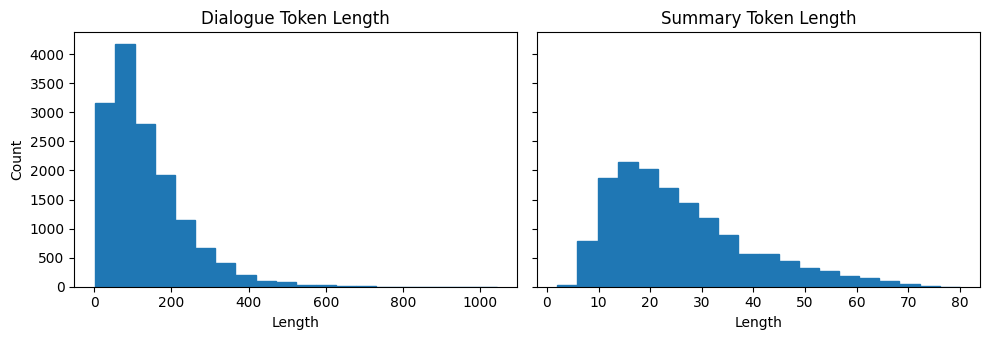

In [29]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

Most of the dialogues are in the range of 100s while summary is in the range of 20 to 30 tokens

Above analysis is useful for data collator to pad/truncate

1. Tokenization 

In [30]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

##### tokenizer.as_target_tokenizer()
Some models require special tokens in the decoder inputs, so it’s important to differentiate between the tokenization of encoder and decoder inputs. In the with statement (called a context manager), the tokenizer knows that it is tokenizing for the decoder and can process sequences accordingly.

In [31]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\transformers\tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

2. Data collator

Padding, shifting labels by one position to not see current or future tokens etc 

In [32]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

3. Trainer Arguments

In [33]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

Model is quite big and hence we set batch size as 1 hurting the convergence. To handle this slow convergence, 

we set gradient_accumulation_steps argument

In gradient accumulation gradient updates, instead of calculating the gradients of the full batch all at once, we make smaller batches and aggregate the gradients. When we have aggregated enough gradients, we run the optimization step.



4. Hugging Face login

In [34]:
from huggingface_hub import notebook_login
notebook_login()

5. Trainer

In [35]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

Cloning https://huggingface.co/pradeepiisc/pegasus-samsum into local empty directory.


In [36]:
trainer.train()


C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\WMYFHCK\AppData\Local\Temp\ipykernel_7052\49973641.py:1 in <module>                     │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\WMYFHCK\\AppData\\Local\\Temp\\ipykernel_7052\\49973641.py'                          │
│                                                                                                  │
│ C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\transformers\trainer.py:1662 │
│ in train                                                                                         │
│                                                                                                  │
│   1659 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1660 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1661 │   │   )                                                                                 │
│ ❱ 1662 │   │   return inner_training_loop(                                                       │
│   1663 │   │   │   args=args,                                                                    │
│   1664 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1665 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\transformers\trainer.py:1929 │
│ in _inner_training_loop                                                                          │
│                                                                                                  │
│   1926 │   │   │   │   │   with model.no_sync():                                                 │
│   1927 │   │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                  │
│   1928 │   │   │   │   else:                                                                     │
│ ❱ 1929 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1930 │   │   │   │                                                                             │
│   1931 │   │   │   │   if (                                                                      │
│   1932 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\transformers\trainer.py:2717 │
│ in training_step                                                                                 │
│                                                                                                  │
│   2714 │   │   │   # loss gets scaled under gradient_accumulation_steps in deepspeed             │
│   2715 │   │   │   loss = self.deepspeed.backward(loss)                                          │
│   2716 │   │   else:                                                                             │
│ ❱ 2717 │   │   │   loss.backward()                                                               │
│   2718 │   │                                                                                     │
│   2719 │   │   return loss.detach()                                                              │
│   2720                                                                                           │
│                                                                                                  │
│ C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-

##### Anyway simple inference was not happening on 4gb gpu, training is far away thing!

##### WE will try to train the same on google colab

##### It took more than 31minutes on google colab to train and more than 12 minutes to evaluate

##### Refer to the notebook named TextSummarizationPegasus_googlecolab.ipynb

In [2]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

In [ ]:
trainer.push_to_hub("Training Complete!")

# END